<a href="https://colab.research.google.com/github/speQtrum/Fixstars_Amplify_Hackathon_2021/blob/main/Submission.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Even Odd Classification using Combinatorial Optimisation**
The problem statement is to divide an array of integers in two subsets. One subset will have only Even numbers and the other will have only odd numbers. Though the problem is very easily solvable using conventional classical computers, but here a different formulation is introduced which is suitable for Ising devices like fixtars Amplify, D'wave or other providers like Hitachi or Fujitsu etc.

In [21]:
# #####################   Necessary Installations  ######################

# !pip install amplify
# !pip install amplify[extra]

In [22]:
#####################   Necessary Imports   ##########################

import numpy as np
import pandas as pd
import networkx as nx
from amplify import BinaryMatrix, BinaryQuadraticModel, gen_symbols, Solver
from amplify.client import FixstarsClient
from amplify.client.ocean import DWaveSamplerClient, LeapHybridSamplerClient

In [23]:
########################################    Helper functions  ###############################

def Best_solution(result):         ## finds best sample from multiple samples
    sols = []                      ## based on highest frequency of occurrence
    for i in range(len(result)):
        y = result[i]
        x = list(y.values.values())
        e = y.energy
        f = y.frequency
        z = {'x':x,'energy':e,'frequency':f}
        sols.append(z)
    df = pd.DataFrame(sols)
    i = int(df[['frequency']].idxmax())
    X = sols[i]['x']
    return X

### **Result subseting and Label Assigning**
Optimisation of the Binary Quadratic Matrix definitely helps us to subset the results into two groups (If binary variable corresponds to an element of input array is **0, then Group_1**, if **1 then Group_2**), but it does not confirm which group is for odd and which one for evens. <br>
Since we choose a group where the number of items is non-zero. Then perform **standard classical even-odd checking** (dividing by 2 and checking remainder) operation **ON THE FIRST ELEMENT**. If the **FIRST ELEMENT** is odd/even, we call that group even/odd subset. 

In [24]:
##################################   Helper functions  ############################


def Subset_result(solution, numbers):  ## Divide the input numbers into 2 subsets
    S1, S2 = [], []                    ## based on best bitarray sample
    subsets = [S1, S2]

    for i in range(len(solution)):
        if solution[i] == 0:
            S1.append(numbers[i])
        elif solution[i] == 1:
            S2.append(numbers[i])
    
    Label_Assignment(subsets)
    print("\nWow! Even and Odd numbers are separated")



def Label_Assignment(subsets):     ## Assigns label to groups as Evens and Odds
    P = None                       
    for i in range(len(subsets)):
        if len(subsets[i]) != 0:  # finding the non-null group
            P = i

    if subsets[P][0] %2 == 0: ### ONLY CHECKS THE FIRST ELEMENT
        even = subsets[P]
        odd = subsets[1-P]
    else:
        odd = subsets[P]
        even = subsets[1-P]
    print(' Even numbers:',even)
    print('  Odd numbers:',odd)

### **QUBO matrix generation for the problem**
Here we are importing **BinaryMatrix** method from amplify. Where i,j th element of the Binary matrix (or QUBO) will be,
$$m_{ij}=(-1)^{(1+N_{i}+N_{j})}$$


In [25]:
##############  Defining QUBO function for QUBO generation from arbitrary array of integers  ##############

def QUBO(N):
    k = N.shape[0]
    m = BinaryMatrix(k)
    for i in range(k):
        for j in range(i,k):
            m[i,j] = (-1)**(1 + N[i] + N[j])
    return m



Here we are generating array of random integers within a range. One can put array of flexible length. For demnonstration purpose a small array (with repetative or non-repetative elements) is chosen. In this approach if we want to classify K numbers, then we will need K number of Logical Variables. Every number is associated with a binary variable, which can take value either 1 or 0.

### **Enter Input Array**

In [26]:
n = 10 # Length of input array        #
                                      #      
N = np.random.randint(1,100,n)        #  ENTER YOUR CUSTOM INPUT HERE    
print('Input numbers are:\n',N)       #
                                      #

qubo = QUBO(N)
print("\n\n       Our QUBO for the problem is:\n\n",qubo.to_numpy())  # Prints QUBO matrix in Numpy array format

model = BinaryQuadraticModel(qubo)  # Converting Binary matrix into amplify native Binary Quadratic Model

Input numbers are:
 [88 84 40 87  4 76 47 18 48 12]


       Our QUBO for the problem is:

 [[-1. -1. -1.  1. -1. -1.  1. -1. -1. -1.]
 [ 0. -1. -1.  1. -1. -1.  1. -1. -1. -1.]
 [ 0.  0. -1.  1. -1. -1.  1. -1. -1. -1.]
 [ 0.  0.  0. -1.  1.  1. -1.  1.  1.  1.]
 [ 0.  0.  0.  0. -1. -1.  1. -1. -1. -1.]
 [ 0.  0.  0.  0.  0. -1.  1. -1. -1. -1.]
 [ 0.  0.  0.  0.  0.  0. -1.  1.  1.  1.]
 [ 0.  0.  0.  0.  0.  0.  0. -1. -1. -1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0. -1. -1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0. -1.]]


### **Graph of the Problem**
The QUBO provides a COMPLETE GRAPH with weights either 1 or -1.


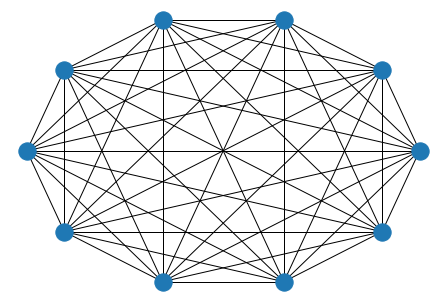

In [27]:
#############  Drawing Graph of the problem from QUBO   ################

G = nx.from_numpy_matrix(qubo.to_numpy())
nx.draw_circular(G,label=True)

### **Solving QUBO with Amplify client**
The result will be a binary array of 0's and 1's. We can filter the input array of integers with respect to the binary array. Elements with value 1 will be in one subset and 0's will be in another subset. 

In [28]:
client = FixstarsClient()
client.token = "mBle_KURyYutT.NDbsTpovEeCWf-vScH"
client.parameters.timeout = 1000
# client.parameters.outputs.duplicate = True  
client.parameters.outputs.num_outputs = 0

################## Solution #########################


solver = Solver(client)
result = solver.solve(model)
for solution in result:
    print(f"values = {list(solution.values.values())} energy = {solution.energy} frequency = {solution.frequency}")

best_solution = Best_solution(result)
print('\n\nInput numbers:',N)
Subset_result(best_solution,N)

values = [1, 1, 1, 0, 1, 1, 0, 1, 1, 1] energy = -36.0 frequency = 1


Input numbers: [88 84 40 87  4 76 47 18 48 12]
 Even numbers: [88, 84, 40, 4, 76, 18, 48, 12]
  Odd numbers: [87, 47]

Wow! Even and Odd numbers are separated


### **Solving QUBO with D'wave clients**
D-wave provides quantum annealing and hybrid solvers.

In [29]:
############# Solving with Dwave client  ##################



client = DWaveSamplerClient()
client.token = "DEV-d1f6e1d1c38fbe9219ce7713e110736473b657a0"
client.solver = "Advantage_system1.1"
client.parameters.num_reads = 1000 


############   Solution   ######################
solver = Solver(client)
result = solver.solve(model)
for solution in result:
    print(f"nvalues = {list(solution.values.values())} energy = {solution.energy} frequency = {solution.frequency}")

best_solution = Best_solution(result)
print('\n\nInput numbers:',N)
Subset_result(best_solution,N)

nvalues = [1, 1, 1, 0, 1, 1, 0, 1, 1, 1] energy = -36.0 frequency = 1000


Input numbers: [88 84 40 87  4 76 47 18 48 12]
 Even numbers: [88, 84, 40, 4, 76, 18, 48, 12]
  Odd numbers: [87, 47]

Wow! Even and Odd numbers are separated


In [30]:
############# Solving with Dwave hybrid client  ##################



client = LeapHybridSamplerClient()
client.token = "DEV-d1f6e1d1c38fbe9219ce7713e110736473b657a0"
client.solver = "hybrid_binary_quadratic_model_version2"
# client.parameters.time_limit = 3

############   Solution   ######################
solver = Solver(client)
result = solver.solve(model)
for solution in result:
    print(f"nvalues = {list(solution.values.values())} energy = {solution.energy} frequency = {solution.frequency}")


best_solution = Best_solution(result)
print('\n\nInput numbers:',N)
Subset_result(best_solution,N)

nvalues = [1, 1, 1, 0, 1, 1, 0, 1, 1, 1] energy = -36.0 frequency = 1


Input numbers: [88 84 40 87  4 76 47 18 48 12]
 Even numbers: [88, 84, 40, 4, 76, 18, 48, 12]
  Odd numbers: [87, 47]

Wow! Even and Odd numbers are separated


### **Conclusion**
This approach provides a new way of separating even-odd numbers from an array using combinatorial optimisation method and provides promising result like classical. <br>
**When the size of the input array becomes larger, Amplify clients (also amplify d-wave wrapper) starts to mis-classify the integers, where vanilla D-wave (QPU and hybrid) gives perfect (100% aaccurate) results even with very large inputs.** This might work as a feedback, and can help to improve fixstars experiences. <br>
Vanilla D-wave implementation link with 500 integer inputs: https://colab.research.google.com/drive/1LJba0qFKqg8-8lFHlvn-9AZ1gb4MUBhg?usp=sharing

$$Thank \space You$$